In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, jaccard_score, log_loss


In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='eLPmJM22mBgYML3U22ySSObCxMqByqePt_EUXVbcyz70',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.ap.cloud-object-storage.appdomain.cloud')

bucket = 'courseraprojectcapstone-donotdelete-pr-bjp4r50kaa9euc'
object_key = 'hmeq.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()
#df_data_1.head()


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
def remove_outlier_IQR(df):
    quan1=df.quantile(0.25)
    quan3=df.quantile(0.75)
    IQR=quan3-quan1
    final = df[~((df < (quan1 - 1.5 * IQR)) | (df > (quan3 + 1.5 * IQR))).any(axis=1)]
    return final

In [4]:
df.info()
df.describe()
df.select_dtypes('object').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


,REASON,JOB
count,5708,5681
unique,2,6
top,DebtCon,Other
freq,3928,2388


In [5]:
null = df.isna().sum()
pct = round((df.isna().sum()/df.shape[0]*100), 2)
null_df = pd.DataFrame(data=null, columns=['Total']).reset_index()
null_df.rename(columns={'index':'Label'}, inplace=True)
null_df['Percentage'] = pct.values
null_df = null_df[null_df['Total'] > 0]
null_df

,Label,Total,Percentage
2,MORTDUE,518,8.69
3,VALUE,112,1.88
4,REASON,252,4.23
5,JOB,279,4.68
6,YOJ,515,8.64
7,DEROG,708,11.88
8,DELINQ,580,9.73
9,CLAGE,308,5.17
10,NINQ,510,8.56
11,CLNO,222,3.72


In [6]:
df[df.duplicated()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


In [7]:
categoric_col = df.select_dtypes('object').columns
for i in categoric_col:
    print(df[i].value_counts())
    print()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64



In [8]:
for i in df.columns:
    print(i, ':', df[i].nunique())

BAD : 2
LOAN : 540
MORTDUE : 5053
VALUE : 5381
REASON : 2
JOB : 6
YOJ : 99
DEROG : 11
DELINQ : 14
CLAGE : 5314
NINQ : 16
CLNO : 62
DEBTINC : 4693


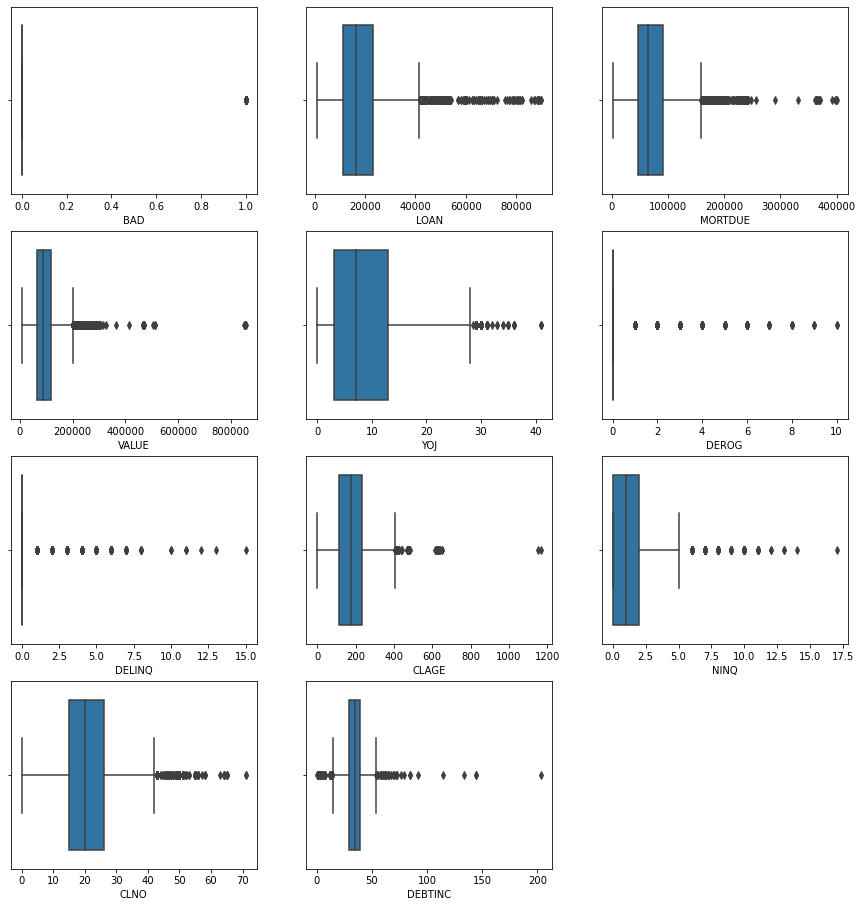

In [9]:
colom_num = df.select_dtypes('number').columns

plt.figure(figsize=(15, 20))
q = 1

for i in colom_num:
    plt.subplot(5, 3, q)
    sns.boxplot(data=df, x=i)
    q += 1

In [10]:
df['REASON'].fillna('No Reason', inplace=True)
df['JOB'].fillna(df['JOB'].mode()[0], inplace=True)
df.fillna(df.median(), inplace=True)

/tmp/wsuser/ipykernel_447/1540932024.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median(), inplace=True)


In [11]:
df.isna().any()

BAD        False
LOAN       False
MORTDUE    False
VALUE      False
REASON     False
JOB        False
YOJ        False
DEROG      False
DELINQ     False
CLAGE      False
NINQ       False
CLNO       False
DEBTINC    False
dtype: bool

In [12]:
df_out = remove_outlier_IQR(df)
number_out = df.shape[0]-df_out.shape[0]
pct_out = (number_out/df.shape[0])

/tmp/wsuser/ipykernel_447/3659872120.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  final = df[~((df < (quan1 - 1.5 * IQR)) | (df > (quan3 + 1.5 * IQR))).any(axis=1)]


In [13]:
colom = ['DELINQ', 'NINQ', 'CLNO']
for i in colom:
    print(df[i].unique())
for i in colom:
    df[i] = df[i].astype('int')
for i in categoric_col:
    df[i] = df[i].astype('category')

[ 0.  2.  1.  6. 15.  4.  3.  5.  7.  8. 10. 12. 11. 13.]
[ 1.  0.  2.  3.  5. 14. 10.  4.  9.  8.  6.  7. 11. 12. 17. 13.]
[ 9. 14. 10. 20.  8. 17. 12. 13. 25. 24. 16. 22.  0.  4. 21. 19. 45. 26.
 37.  3.  2. 27.  7. 36. 33.  6. 28. 11. 31. 15. 18. 23.  5. 30. 34. 42.
 50. 47. 32. 29. 46. 38. 40. 49. 43. 35.  1. 56. 39. 51. 55. 65. 57. 41.
 71. 48. 53. 64. 52. 63. 44. 58.]


In [14]:
df.dtypes

BAD           int64
LOAN          int64
MORTDUE     float64
VALUE       float64
REASON     category
JOB        category
YOJ         float64
DEROG       float64
DELINQ        int64
CLAGE       float64
NINQ          int64
CLNO          int64
DEBTINC     float64
dtype: object

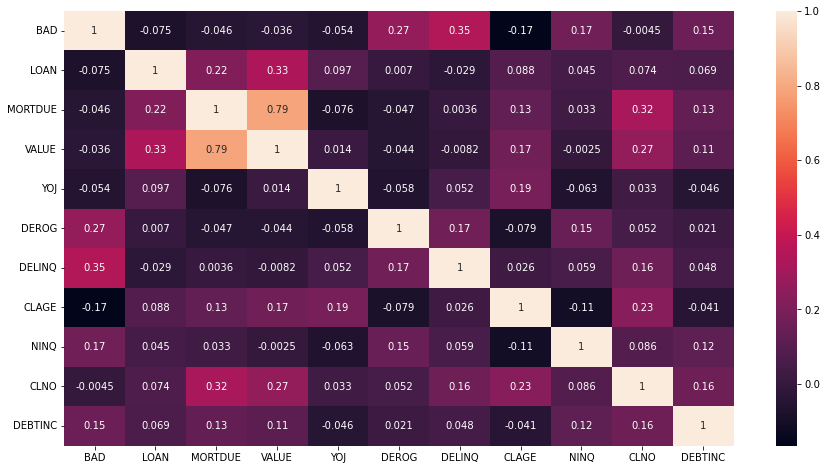

In [15]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()


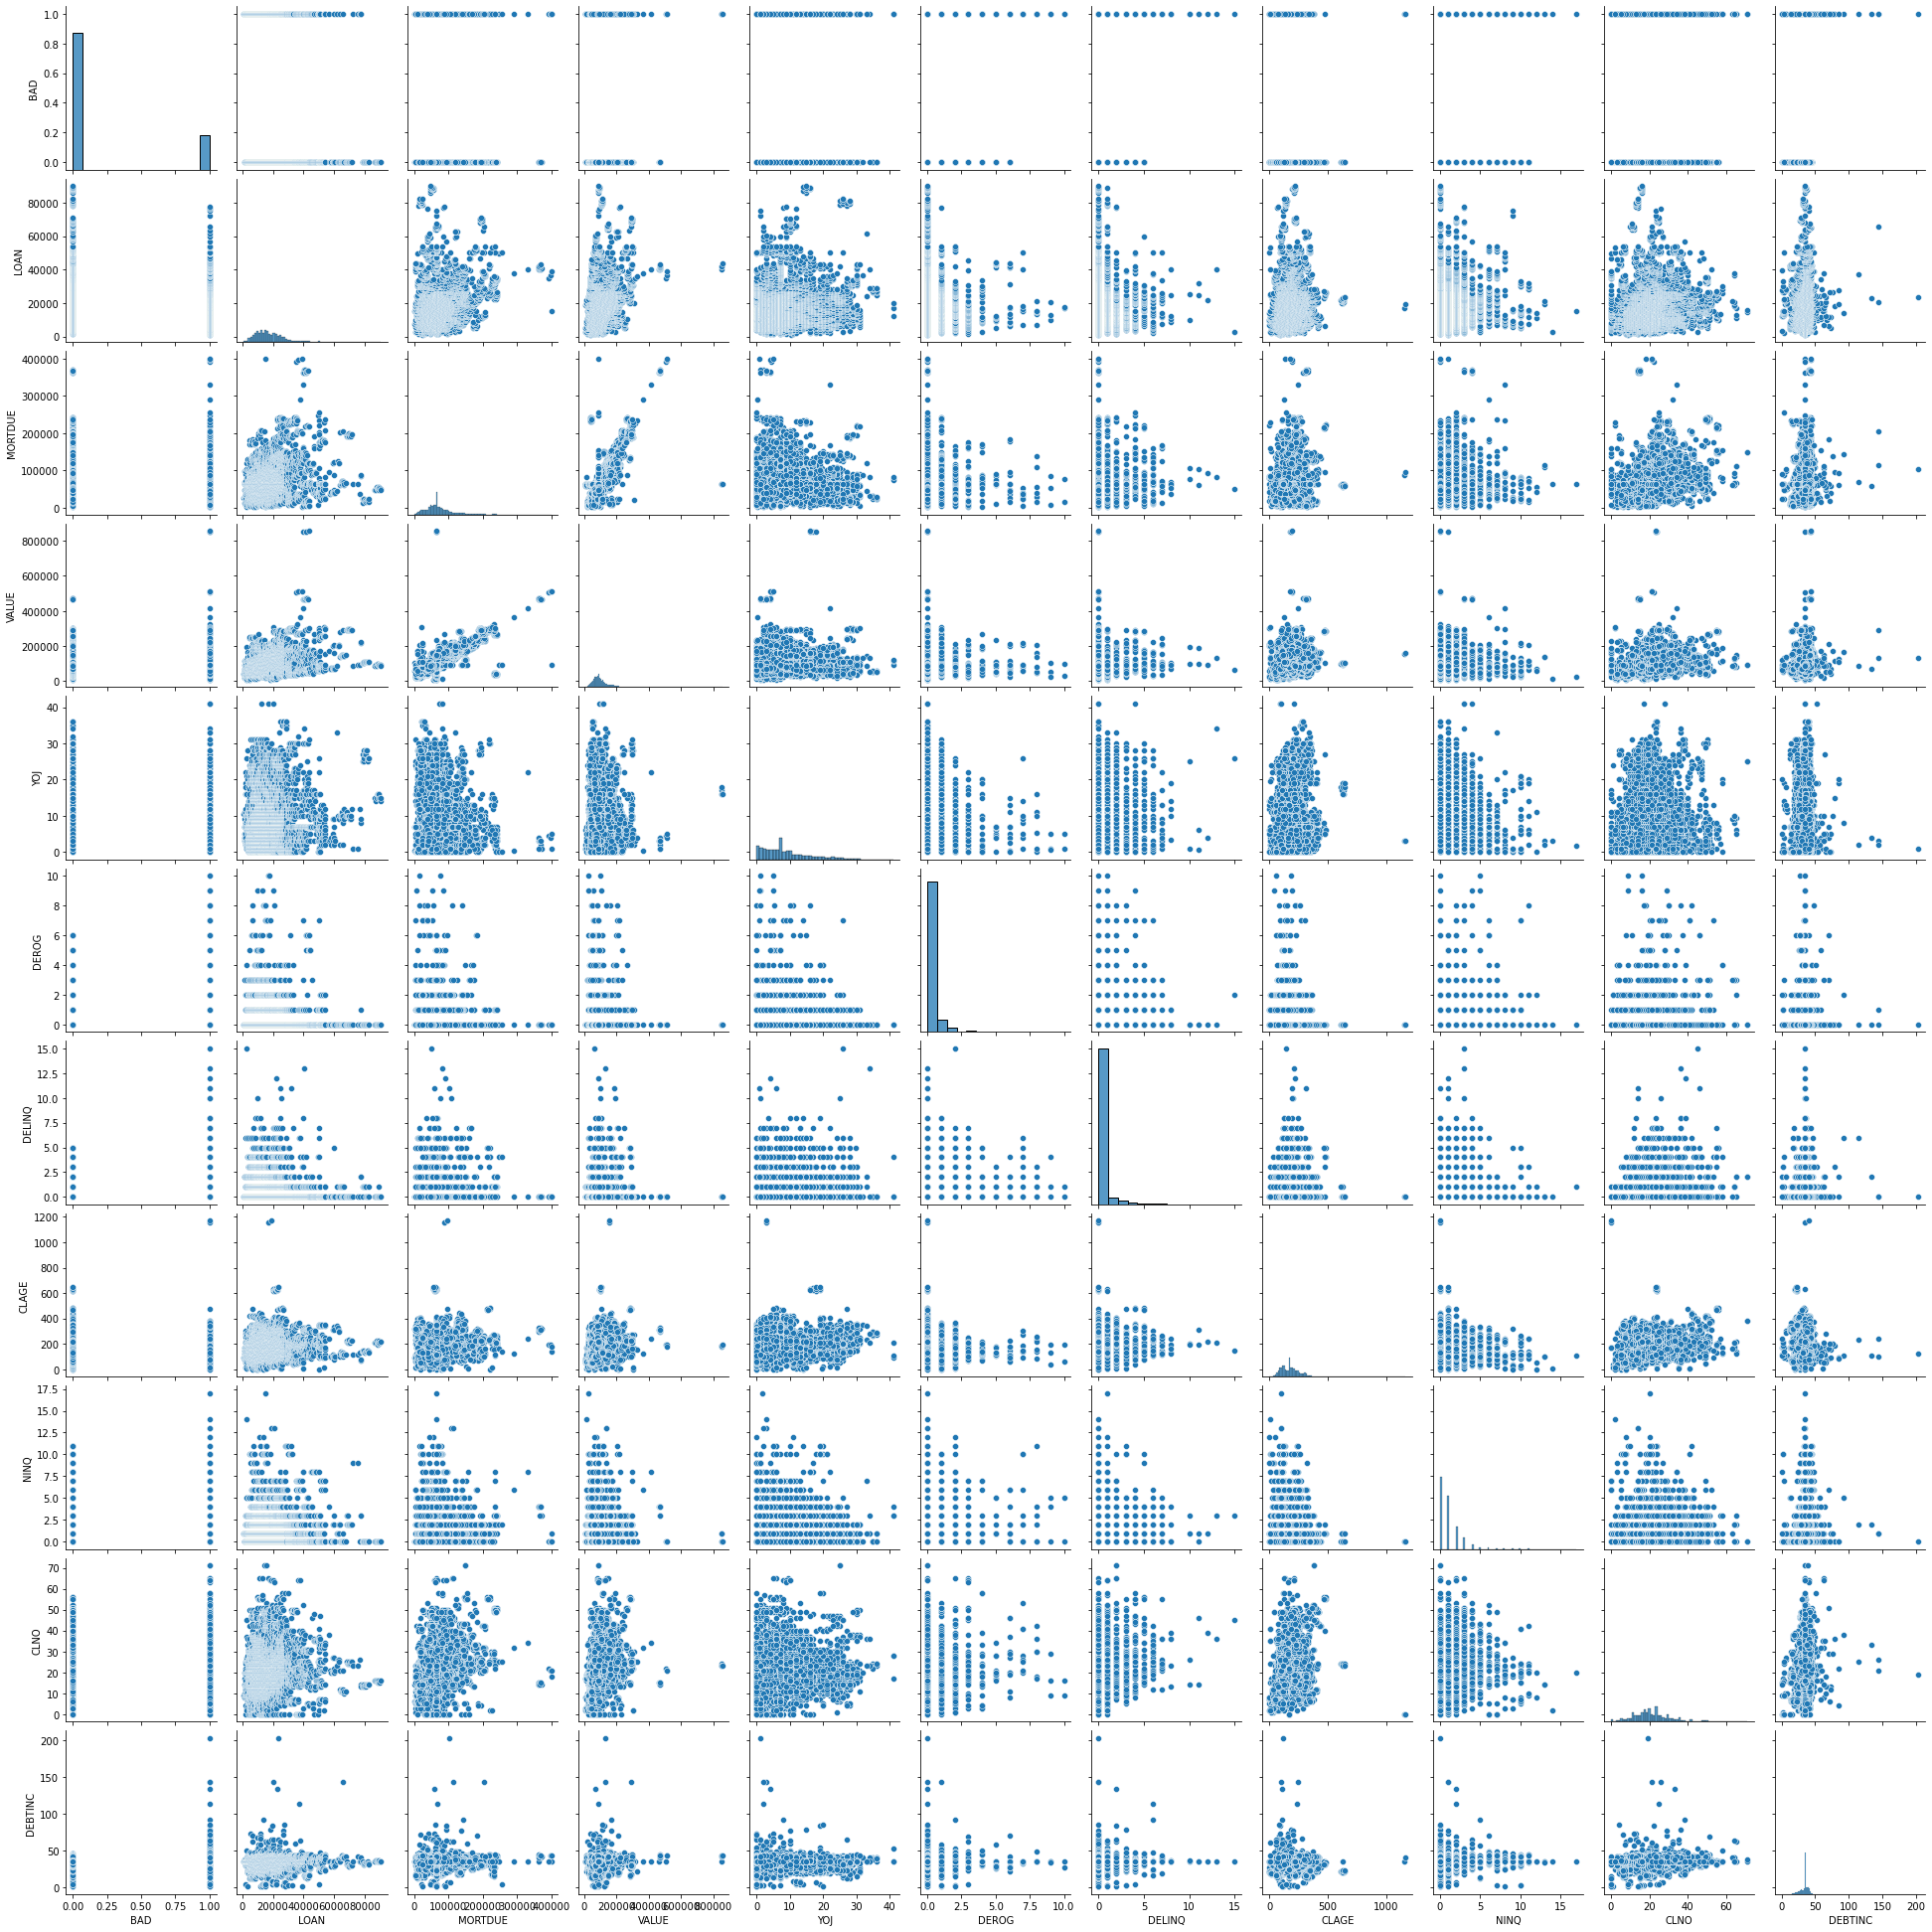

In [16]:
sns.pairplot(df)
plt.show()


In [17]:
df['PROBINC'] = df['MORTDUE']/df['DEBTINC'] 

In [18]:
enc = pd.get_dummies(df[['REASON', 'JOB']], prefix=['reason', 'job'])
df = pd.concat([df, enc], axis=1)
df.drop(['REASON', 'JOB'], axis=1, inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,PROBINC,reason_DebtCon,reason_HomeImp,reason_No Reason,job_Mgr,job_Office,job_Other,job_ProfExe,job_Sales,job_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0,94.366667,1,9,...,742.713698,0,1,0,0,0,1,0,0,0
1,1,1300,70053.0,68400.0,7.0,0.0,2,121.833333,0,14,...,2011.961435,0,1,0,0,0,1,0,0,0
2,1,1500,13500.0,16700.0,4.0,0.0,0,149.466667,1,10,...,387.727569,0,1,0,0,0,1,0,0,0
3,1,1500,65019.0,89235.5,7.0,0.0,0,173.466667,1,20,...,1867.382132,0,0,1,0,0,1,0,0,0
4,0,1700,97800.0,112000.0,3.0,0.0,0,93.333333,0,14,...,2808.870831,0,1,0,0,1,0,0,0,0


In [19]:
x = df.drop(['BAD'], axis=1)
y = df['BAD']

In [20]:
tf = RobustScaler().fit_transform(x)
scaledf = pd.DataFrame(tf, columns=x.columns)
scaledf['BAD'] = y
scaledf

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,...,reason_DebtCon,reason_HomeImp,reason_No Reason,job_Mgr,job_Office,job_Other,job_ProfExe,job_Sales,job_Self,BAD
0,-1.245902,-0.977478,-0.956113,0.388889,0.0,0.0,-0.720587,0.0,-1.000000,0.000000,...,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,-1.229508,0.125658,-0.396751,0.000000,0.0,2.0,-0.470370,-0.5,-0.545455,0.000000,...,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,-1.213115,-1.286006,-1.381227,-0.333333,0.0,0.0,-0.218636,0.0,-0.909091,0.000000,...,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,-1.213115,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,-1.196721,0.818272,0.433484,-0.444444,0.0,0.0,-0.730000,-0.5,-0.545455,0.000000,...,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,5.950820,-0.193579,0.018080,1.000000,0.0,0.0,0.440387,-0.5,-0.363636,0.180066,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5956,5.959016,-0.260676,0.070484,1.000000,0.0,0.0,0.320897,-0.5,-0.454545,0.144949,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5957,5.975410,-0.273931,0.070237,0.888889,0.0,0.0,0.353580,-0.5,-0.454545,0.102735,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5958,6.024590,-0.365665,0.049995,0.777778,0.0,0.0,0.368274,-0.5,-0.363636,-0.066425,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [21]:
X = scaledf.drop('BAD', axis=1)
y = scaledf['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4768, 20) (4768,) (1192, 20) (1192,)


In [22]:
classifiers = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(), 
    LogisticRegression(),
    SVC()]
model_performance = pd.DataFrame(columns=['Method', 'jaccard','logloss', 'f1-score'])

In [23]:
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    method = str(type(classifier)).split('.')[-1][:-2]
    f1 = f1_score(y_test, y_pred)
    jass = jaccard_score(y_test, y_pred, average='macro')
    logloss = log_loss(y_test, y_pred,eps=1e-15, normalize=True, sample_weight=None, labels=None)
    model_performance = model_performance.append({
        'Method':method,
        'jaccard':jass,
        'logloss':logloss,
        'f1-score':f1}, ignore_index=True)


In [24]:
model_performance.sort_values([ 'logloss', 'f1-score', 'jaccard'], ascending=False).reset_index(drop=True)


,Method,jaccard,logloss,f1-score
0,LogisticRegression,0.547841,6.229754,0.450128
1,DecisionTreeClassifier,0.656249,5.099736,0.652174
2,SVC,0.608373,4.954813,0.544000
3,KNeighborsClassifier,0.629177,4.723011,0.580977
